In [1]:
% pylab inline
import numpy as np
#import numpy
import sklearn
from sklearn.preprocessing import Imputer
import matplotlib.pyplot as plt
from sklearn import ensemble

Populating the interactive namespace from numpy and matplotlib


In [2]:
#lightc1 = np.load('KeplerSampleWErr_GoodErr_RM.npy')
#lightc2 = np.load('KeplerSampleWErrSparse_RM.npy')

lightc1 = np.load('KeplerSampleWErr.npy')
lightc2 = np.load('KeplerSampleWErrSparse.npy')

In [3]:
print shape(lightc1)
print shape(lightc2)

(2500, 3, 100)
(2500, 3, 50)


In [4]:
X = lightc1[:,1,:]
print shape(X)

(2500, 100)


(array([  2.00000000e+00,   1.20000000e+01,   2.46000000e+03,
          1.40000000e+01,   1.00000000e+00,   4.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.00000000e+00]),
 array([ 0.90457952,  0.93943046,  0.97428141,  1.00913235,  1.04398329,
         1.07883424,  1.11368518,  1.14853612,  1.18338706,  1.21823801,
         1.25308895]),
 <a list of 10 Patch objects>)

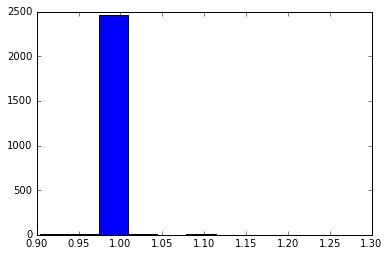

In [5]:
plt.hist(X[:,0][X[:,0] > 0.9],bins=10)

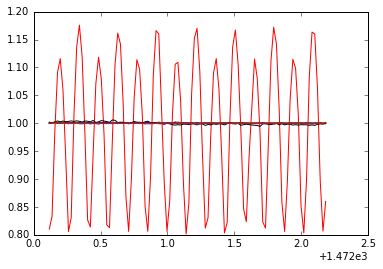

In [6]:
#plt.plot(lightc1[0][0][:],lightc1[0][1][:])
#plt.plot(lightc2[0][0][:],lightc2[0][1][:])
for i in arange(10,20): plt.plot(lightc1[i,0,:],X[i,:])
#plt.plot(lightc1[0][0][:],X[0,:])

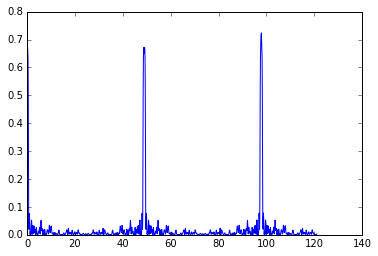

In [16]:
from scipy import signal
from astropy.stats import LombScargle
for i in arange(10): f, Pxx_den = LombScargle(lightc1[i,0,:], X[i,:]).autopower()
#f, Pxx_den = signal.periodogram(X[33,:])
plt.plot(f, Pxx_den)

I will get periodograms for all lcvs and use the individual components of the resulting power spectrum as the features. This is of course better than just using the fluxes, since there can be phase differences, etc.

In [17]:
periodograms1 = []

for i in arange(2500): 
    f, Pxx_den = LombScargle(lightc1[i,0,:], X[i,:]).autopower()
    periodograms1.append(Pxx_den)
    
periodograms1 = np.array(periodograms1)

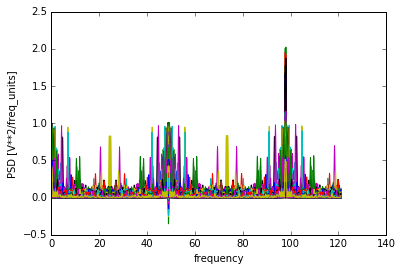

In [18]:
#periodograms1[np.where(periodograms1 <= 0.0)] = median(periodograms1)
for i in arange(1000): plt.plot(f, periodograms1[i])
plt.xlabel('frequency')
plt.ylabel('PSD [V**2/freq_units]')

In [19]:
#periodograms = log10(periodograms1)
periodograms = periodograms1
obj_ids = numpy.arange(len(periodograms))
print obj_ids

[   0    1    2 ..., 2497 2498 2499]


[ 0.13568958  0.02021313  0.04223651 ...,  0.22553375  0.08918447
  0.90846349]
[ 0.00917832  0.33612696  0.18569229 ...,  0.37038222  0.12811479
  0.7081226 ]


(array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
         2136.,   364.,     0.]),
 array([-12.        , -11.26315789, -10.52631579,  -9.78947368,
         -9.05263158,  -8.31578947,  -7.57894737,  -6.84210526,
         -6.10526316,  -5.36842105,  -4.63157895,  -3.89473684,
         -3.15789474,  -2.42105263,  -1.68421053,  -0.94736842,
         -0.21052632,   0.52631579,   1.26315789,   2.        ]),
 <a list of 19 Patch objects>)

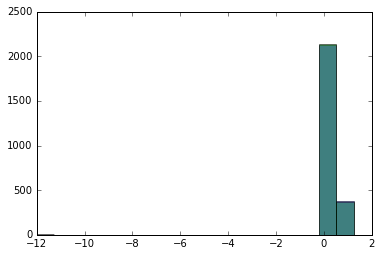

In [20]:
obs_vec = periodograms[:,4]
syn_vec = numpy.random.choice(obs_vec, len(obs_vec))
print obs_vec
print syn_vec
plt.hist(obs_vec,bins=numpy.linspace(-12, 2, 20),alpha=0.5)
plt.hist(syn_vec,bins=numpy.linspace(-12, 2, 20),alpha=0.5)

In [21]:
print periodograms[1]

[ 0.00993805  0.01073062  0.01252251 ...,  0.00449048  0.0083533
  0.01353455]


The features will be the fluxes, so we have 100 features in total. Let's create sythetic data that has the same marginal distributions of the real data. We will use the dense curves. This is all based on Dalya's algorithm. Really cool.

In [22]:
def return_synthetic_data(X):
    """
    The function returns a matrix with the same dimensions as X but with synthetic data
    based on the marginal distributions of its featues
    """
    features = len(X[0])
    X_syn = numpy.zeros(X.shape)

    for i in xrange(features):
        obs_vec = X[:,i]
        syn_vec = numpy.random.choice(obs_vec, len(obs_vec)) # here we chose the synthetic data to match the marginal distribution of the real data
        X_syn[:,i] += syn_vec

    return X_syn

X_syn = return_synthetic_data(periodograms)

In [23]:
print periodograms[:,0]

[ 0.16311631  0.00993805  0.02494384 ...,  0.34277016  0.17898485
  0.94058293]


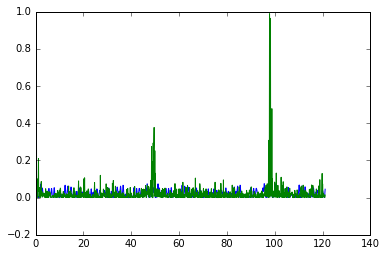

In [24]:
plt.plot(f,periodograms[10])
plt.plot(f,X_syn[10][:])
#plt.ylim(0.995,1.005)

(array([ 1239.,   386.,   194.,   142.,   106.,    71.,    72.,    71.,
           89.,   130.]),
 array([  4.55321951e-05,   9.99835264e-02,   1.99921521e-01,
          2.99859515e-01,   3.99797509e-01,   4.99735503e-01,
          5.99673497e-01,   6.99611492e-01,   7.99549486e-01,
          8.99487480e-01,   9.99425474e-01]),
 <a list of 10 Patch objects>)

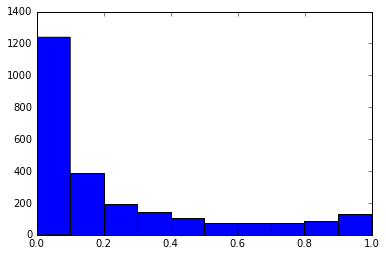

In [27]:
plt.hist(periodograms[:,2])

Now lets plot the marginal distributions of the *'real'* and *'synthetic'* data and make sure that they match for a given feature:

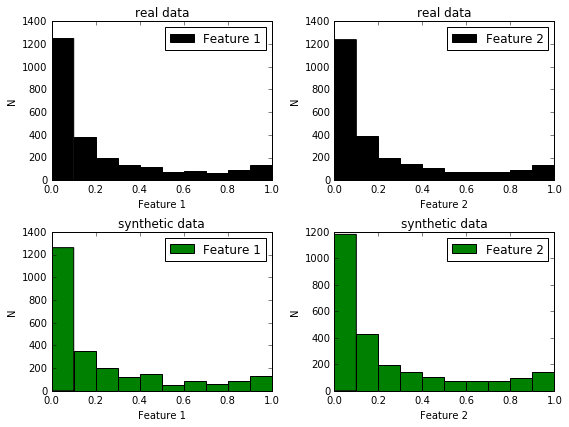

In [28]:
plt.rcParams['figure.figsize'] = 8, 6

plt.subplot(2, 2, 1)
plt.title("real data")
tmp = plt.hist(periodograms[:, 0], color="k", label="Feature 1")
plt.legend(loc="best")
plt.xlabel("Feature 1")
plt.ylabel("N")


plt.subplot(2, 2, 2)
plt.title("real data")
tmp = plt.hist(periodograms[:, 2], color="k", label="Feature 2")
plt.legend(loc="best")
plt.xlabel("Feature 2")
plt.ylabel("N")


plt.subplot(2, 2, 3)
plt.title("synthetic data")
tmp = plt.hist(X_syn[:, 0], color="g", label="Feature 1")
plt.legend(loc="best")
plt.xlabel("Feature 1")
plt.ylabel("N")


plt.subplot(2, 2, 4)
plt.title("synthetic data")
tmp = plt.hist(X_syn[:, 2], color="g", label="Feature 2")
plt.legend(loc="best")
plt.xlabel("Feature 2")
plt.ylabel("N")


plt.tight_layout()

In [29]:
def merge_work_and_synthetic_samples(X, X_syn):
    """
    The function merges the data into one sample, giving the label "1" to the real data and label "2" to the synthetic data
    """
    # build the labels vector
    Y = numpy.ones(len(X))
    Y_syn = numpy.ones(len(X_syn)) * 2

    Y_total = numpy.concatenate((Y, Y_syn))
    X_total = numpy.concatenate((X, X_syn))
    return X_total, Y_total

X_total, Y_total = merge_work_and_synthetic_samples(periodograms, X_syn)
# declare an RF
N_TRAIN = 50 # number of trees in the forest
rand_f = sklearn.ensemble.RandomForestClassifier(n_estimators=N_TRAIN)
rand_f.fit(X_total, Y_total)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [30]:
def build_similarity_matrix(rand_f, X):
    """
    The function builds the similarity matrix based on the feature matrix X for the results Y
    based on the random forest we've trained
    the matrix is normalised so that the biggest similarity is 1 and the lowest is 0

    This function counts only leaves in which the object is classified as a "real" object 
    it is also implemented to optimize running time, asumming one has enough running memory
    """
    # apply to get the leaf indices
    apply_mat = rand_f.apply(X)
    # find the predictions of the sample
    is_good_matrix = numpy.zeros(apply_mat.shape)
    for i, est in enumerate(rand_f.estimators_):
        d = est.predict_proba(X)[:, 0] == 1
        is_good_matrix[:, i] = d
    # mark leaves that make the wrong prediction as -1, in order to remove them from the distance measurement
    apply_mat[is_good_matrix == False] = -1 
    # now calculate the similarity matrix
    sim_mat = numpy.sum((apply_mat[:, None] == apply_mat[None, :]) & (apply_mat[:, None] != -1) & (apply_mat[None, :] != -1), axis=2) / numpy.asfarray(numpy.sum([apply_mat != -1], axis=2), dtype='float')
    return sim_mat

sim_mat = build_similarity_matrix(rand_f, periodograms)
dis_mat = 1 - sim_mat

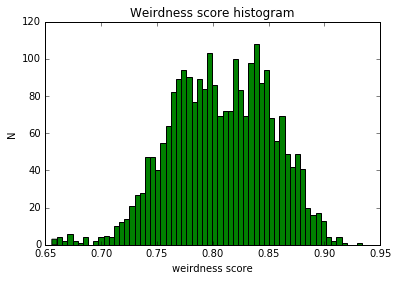

In [31]:
sum_vec = numpy.sum(dis_mat, axis=1)
sum_vec /= float(len(sum_vec))

plt.rcParams['figure.figsize'] = 6, 4
plt.title("Weirdness score histogram")
tmp = plt.hist(sum_vec, bins=60, color="g")
plt.ylabel("N")
plt.xlabel("weirdness score")

In [32]:
print sum_vec

[ 0.88230657  0.82798794  0.76425185 ...,  0.84261708  0.77892794
  0.85655842]


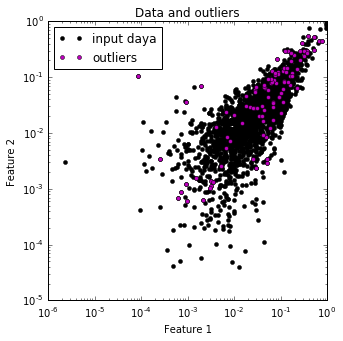

In [33]:
N_outliers = 100
sum_vec_outliers = numpy.sort(sum_vec)[::-1][:N_outliers]
obj_ids_outliers = obj_ids[numpy.argsort(sum_vec)][::-1][:N_outliers]

plt.rcParams['figure.figsize'] = 5, 5
plt.title("Data and outliers")
plt.plot(periodograms[:,10], periodograms[:,11], "ok", label="input daya", markersize=4)
plt.plot(periodograms[obj_ids_outliers, 10], periodograms[obj_ids_outliers, 11], "om", label="outliers", markersize=4)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")	
plt.legend(loc="best")
plt.xscale('log')
plt.yscale('log')

In [34]:
print shape(X)
print shape(lightc1[obj_ids_outliers,0,:])


(2500, 100)
(100, 100)


In [38]:
N_outliers = 100
sum_vec_outliers = numpy.sort(sum_vec)[::-1][:N_outliers]
obj_ids_outliers = obj_ids[numpy.argsort(sum_vec)][::-1][:N_outliers]

sum_vec_outliers1 = numpy.sort(sum_vec)[:N_outliers]
obj_ids_outliers1 = obj_ids[numpy.argsort(sum_vec)][:N_outliers]

print obj_ids_outliers
print obj_ids_outliers1

#plt.rcParams['figure.figsize'] = 5, 5

#plt.plot(lightc1[obj_ids_outliers,0,:],X[obj_ids_outliers,:])

#plt.title("Data and outliers")
#plt.plot(periodograms[:,2], periodograms[:,3], "ok", label="input daya", markersize=4)
#plt.plot(periodograms[obj_ids_outliers, 2], periodograms[obj_ids_outliers, 3], "om", label="outliers", markersize=4)
#plt.xlabel("Feature 1")
#plt.ylabel("Feature 2")	
#plt.legend(loc="best")

[1560 1781 1089 1802  515  536 1145  753  865 1964 1641 1216 1420 2418 1648
  652 1096 1689 1358 1156    9 2280  722 1577 1255 1698 1773 1458  360  497
 2091 2185 2368  977 2221 2326 1600 1500  573 1328  223 1367   15  124 1591
 2250 1464 1057 1033  201 1361 2205 2382 2336 1000 1601 1108 1871 1297  831
 1991 2049  986 1906  660 1799 2304  884 1720  109  627 2164 1833 1424  319
 1552  617  380 1412 1563 2396  969  270 2405  326    0  681  454 1752  897
  533 1258  251 2288  453 1785 1669 2377  221 1449]
[ 855 1987 1377 1495 2006 1501  378 2359 1221 2496  450 1203 1859 1038   64
 2322 2140 1126  392  226  156 1373  947 2138 1225 2381 2036  689 2170 1897
  572  561  773 1765   74 1618 1787   72 1414 1252 1696  548  172 1235  835
  809 2400  171 2073  680  914  463 2463 1867  193  785 1510 1161 1291 2232
 2356 1188 1101  695 2011  908  665 1427   28 1812  435 2439   85  844 2246
 2075  187 2350  131  826  618  989  604  789 1523  909 1775  486 2493   41
  474 1701  921 2460 2101 2483  212 

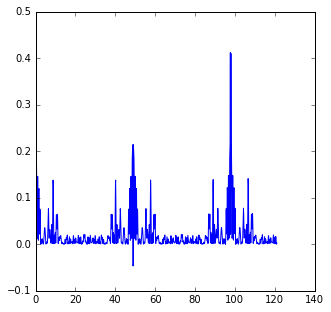

In [36]:
plt.plot(f,periodograms[1190])

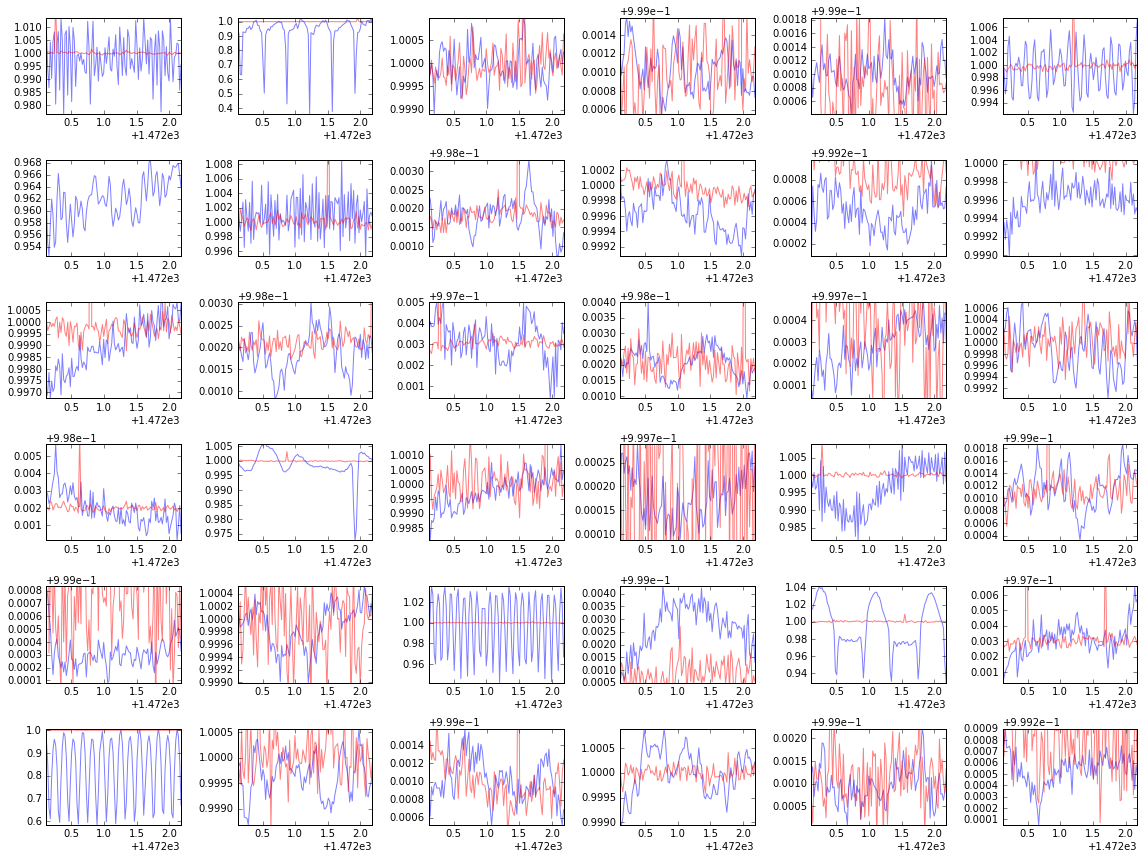

In [37]:
plt.rcParams['figure.figsize'] = 16, 12
for i in arange(36): 
    #print i
    #print obj_ids_outliers[i]
    plt.subplot(6, 6, i+1)
    plt.plot(lightc1[obj_ids_outliers[i],0,:],X[obj_ids_outliers[i],:],color='b',alpha=0.5)
    axis('tight')
    #plt.axis('off')
    plt.plot(lightc1[obj_ids_outliers1[i],0,:],X[obj_ids_outliers1[i],:],color='r',alpha=0.5)
plt.tight_layout()    
plt.savefig('weirdness.png')

#plt.plot(lightc1[1150,0,:],X[1150,:],color='b')
#plt.plot(lightc1[1190,0,:],X[1190,:],color='b')
#plt.plot(lightc1[1552,0,:],X[1552,:],color='b')


#plt.plot(lightc1[423,0,:],X[423,:],color='r')
#plt.plot(lightc1[576,0,:],X[576,:],color='r')
#plt.plot(lightc1[2240,0,:],X[2240,:],color='r')

In [ ]:
plt.rcParams['figure.figsize'] = 8, 6
for i in arange(25): 
    #print i
    #print obj_ids_outliers[i]
    plt.subplot(5, 5, i+1)
    plt.plot(lightc1[obj_ids_outliers[i],0,:],X[obj_ids_outliers[i],:],color='b')
    axis('tight')
    #plt.axis('off')
    #plt.scatter(lightc1[obj_ids_outliers1[i],0,:],X[obj_ids_outliers1[i],:],color='r',alpha=0.5)
plt.tight_layout()    